## Reproduce Old Model
---

Due to data availability, we need to remove a few features from the ACH and MCD models. This rendered the old model during development useless, which led us to produce a old version fitted on the original dataset.

We will reproduce it in this notebook

In [1]:
import json, sys, os

sys.path.insert(1, "../..")
import pandas as pd
import numpy as np
import pickle as pkl
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
import rdsutils.plot as rdsplot
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import smart_open
import src.preprocessing.utils as pu
plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

In [2]:
modeling_df = pd.read_parquet('s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-05-19/SCORED_modeling_df.parquet')
test_df = pd.read_parquet('s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-05-19/SCORED_test_df.parquet')

In [3]:
modeling_df = modeling_df[modeling_df.transaction_datetime.between(
                    pd.to_datetime('2020-05-01'), pd.to_datetime('2020-07-31'))]

<AxesSubplot:>

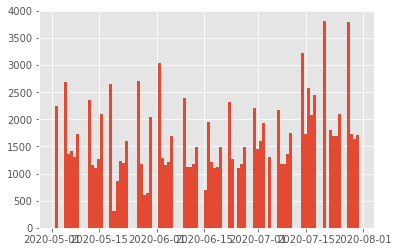

In [10]:
modeling_df.transaction_datetime.hist(bins=100)

In [4]:
modeling_df = pu.preprocess(modeling_df)
test_df = pu.preprocess(test_df)

In [5]:
with open("../../config.json", "r") as f:
    config = json.load(f)
params = config["model_params"]
params["early_stopping_round"] = None

In [6]:
clf = lgb.LGBMClassifier(**params)
X = modeling_df[config["features"]]
y = modeling_df[config["target_col"]]
clf.fit(X, y)

/home/ec2-user/anaconda3/envs/deposit_v2/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/deposit_v2/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: seed_value
[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0
[LightGBM] [Warning] seed is set=12345, random_state=12345 will be ignored. Current value: seed=12345
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0


LGBMClassifier(boost_from_average='false', boosting='gbdt',
               early_stopping_round=None, feature_fraction=0.8, lambda_l1=30.0,
               lambda_l2=50.0, max_depth=5, mc_method='basic', metric=['auc'],
               min_data_in_leaf=121,
               monotone_constraints=[-1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1,
                                     -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1],
               num_iterations=215, num_leaves=52, objective='binary',
               random_state=12345, scale_pos_weight=20.34585956416465,
               seed=12345, seed_value=12345, tree_learner='feature',
               verbose=-1)

In [7]:
with open("../../models/money-deposit-risk-v2-ach-dev.pkl", "wb") as f:
    pkl.dump(clf, f)

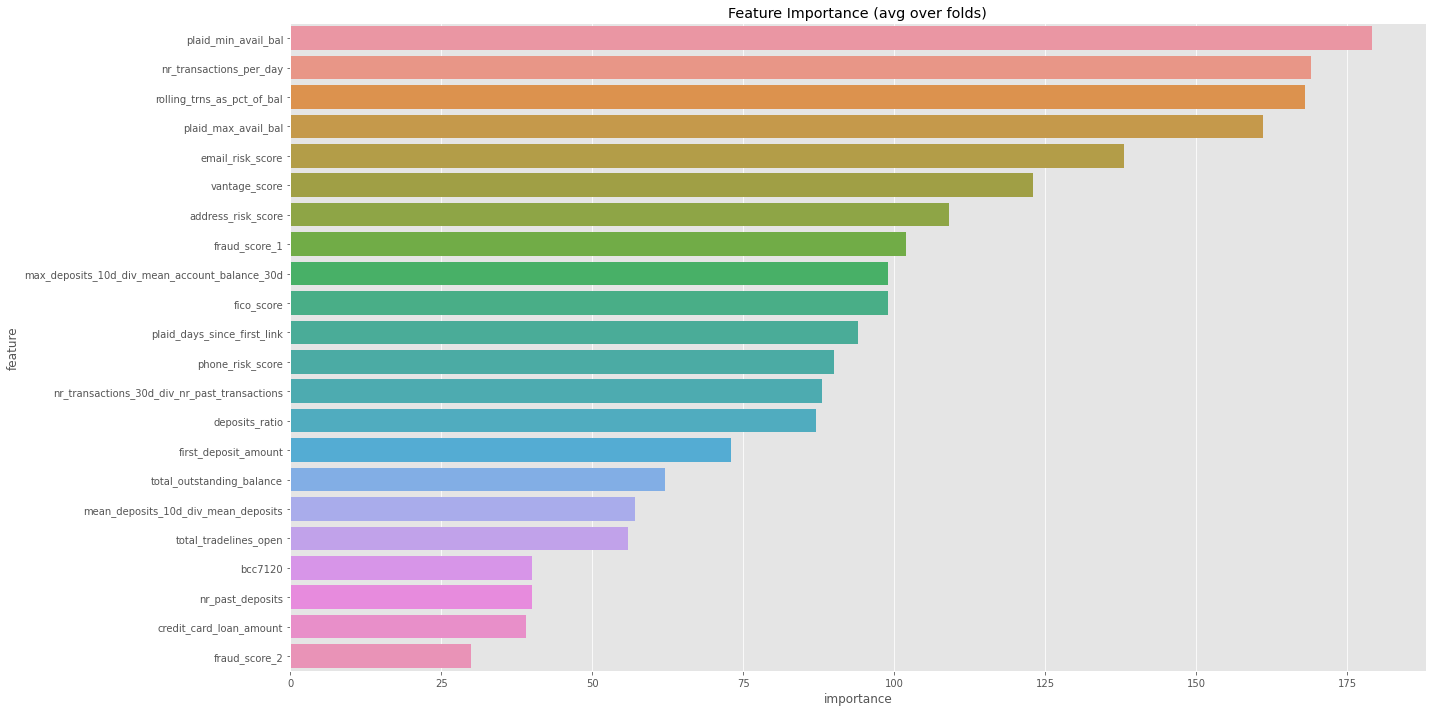

In [8]:
fig, axs = rdsplot.display_feature_importance(clf.feature_name_,
                                   clf.feature_importances_, 
                                   max_n_features=-1, figsize=(20,10)) 